# Hi'iaka occultation

[Hiʻiaka](https://en.wikipedia.org/wiki/Hi%CA%BBiaka_(moon)) is the largest, outer moon of the trans-Neptunian dwarf planet Haumea. We observed Hiʻiaka occulting a bright star, helping in the study of the moon's orbital and physical parameters. 

This observation was done with the 1-m telescope [Artemis](https://www.speculoos.uliege.be/cms/c_4549211/en/speculoos-north-sno) and consists of 1 s. short exposures, requiring images to be small in size (46x41 pixels to reduce the overhead time of the telescope). In this tutorial, we will extract the raw flux time-series of the star occulted by Hi'iaka.

## Images

We start by scanning our dataset

In [1]:
from prose import FitsManager, utils

fm = FitsManager("/Users/lgrcia/data/Hiaka_occultation_20220609_Artemis", depth=1)
fm.observations(hide_exposure=False)

RUN Parsing FITS:  47%|███████▉         | 263/561 [00:00<00:00, 1317.24images/s]

INFO telescope  not found - using default


RUN Parsing FITS: 100%|█████████████████| 561/561 [00:00<00:00, 1331.57images/s]


,date,telescope,filter,type,target,width,height,exposure,files
id,,,,,,,,,
1,2022-06-09,,Clear,light,2002MS4_Artemis_clear_2x2bin,46,41,1.0,556
2,2022-06-09,,,bias,2002MS4_Artemis_clear_2x2bin,46,41,0.0,5


For this observation we only have bias calibration images.  We see that some images could not be recognized. To solve this problem we can define an Image loader with the telescope pre-defined

In [2]:
from prose import Image

loader = Image.from_telescope("Artemis")

## Reference

We then detect the stars for which the photomety will be extracted

INFO Building master bias
INFO No dark images set
INFO No flat images set


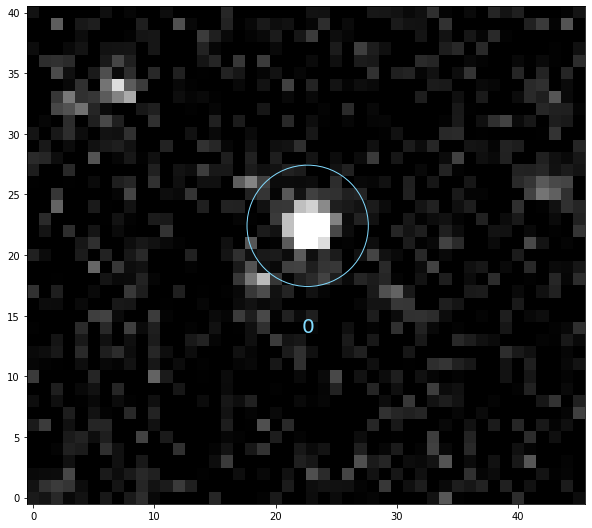

In [3]:
from prose import Sequence, blocks, Image

images = fm.all_images
ref = loader(images[0])

calibration = Sequence([
    blocks.Calibration(bias=fm.all_bias, loader=loader),
    blocks.SegmentedPeaks(n_stars=1, auto=True)
])

calibration.run(ref, show_progress=False, loader=loader)
_ = ref.show(ms=5, fs=20, zscale=False)

## The reduction sequence

In [4]:
# to retrieve time and flux from images
data = blocks.Get("jd_utc", "fluxes")

reduction = Sequence([
    *calibration,
    blocks.Set(stars_coords=ref.stars_coords.copy()), # coordinates of the stars
    blocks.centroids.Quadratic(limit=4),
    blocks.PhotutilsAperturePhotometry(scale=False), # aperture photometry
    data
])

reduction.run(images, loader=loader)

RUN 100%|█████████████████████████████████| 556/556 [00:11<00:00, 49.02images/s]


we can now vizualise our light curve

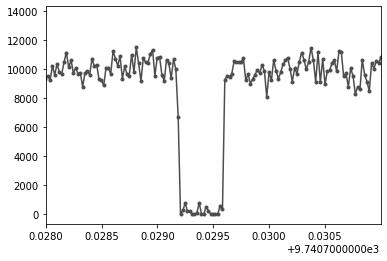

In [5]:
import numpy as np
import matplotlib.pyplot as plt

time = np.array(data.jd_utc)
fluxes = np.array(data.fluxes) # shape is (time, apertures, stars)

# plotting aperture 10, star 0
flux = fluxes[:, 10, 0]
plt.plot(time - 2450000, flux, ".-", c="0.3")
_ = plt.xlim(9740.728, 9740.731)

This is a full occultation that we should be able to see on the images directly!

## Seeing the star disapear

In order to see the images as they are processed, we will use the blocks from the `prose.blocks.vizualisation` module. The `PlotVideo` block takes a plotting function as argument, which takes as input an `Image` object. Let's implement it

In [6]:
def plot(image):
    plt.figure(None, (10,4))
    ax = plt.subplot(121, xlabel="JD-utc - 2450000", ylabel="diff. flux")
    time.append(image.jd_utc - 2450000)
    flux.append(image.fluxes[10,0]/10000)
    ax.plot(time, flux, ".-", c="0.3")
    plt.xlim(9740.7285, 9740.7305)
    ax.set_ylim(-0.2, 1.3)
    ax.set_title(f"Artemis 2002MS4 occultation ({ref.date.date()})")
    ax2 = plt.subplot(122)
    image.show(zscale=False, ms=5, fs=20, ax=ax2)
    plt.tight_layout()

and use it within a sequence that also contain the photometric extraction blocks

In [7]:
# this is set in plot
time = []; flux = []

viz = Sequence([
    *reduction,
    blocks.vizualisation.PlotVideo(plot, "static/hiaka.gif", fps=17)
])

# Only the images close to the occultation
viz.run(images[191:260], loader=loader)

RUN 100%|███████████████████████████████████| 69/69 [00:06<00:00, 10.34images/s]


Here is the `movie.gif` where we indeed see the star being occulted

![](static/hiaka.gif)